In [16]:
!pip install pybaseball

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pybaseball as pb 
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (train_test_split, cross_validate, 
                                     GridSearchCV)
from sklearn.linear_model import (LinearRegression, Ridge,
                                  Lasso, ElasticNet)
from sklearn.metrics import mean_squared_error, r2_score
from yellowbrick.regressor import ManualAlphaSelection
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)

# Make this notebook's output stable across runs
random_state = 1000
np.random.seed(random_state)

# Do not use scientific notation in pandas tables
pd.options.display.float_format = '{:,.4f}'.format

In [18]:
# Get range for past decade (2013-2022)
years = range(2013, 2023) 

In [19]:
# create a dictionary of team names and abbreviations
teams = {
    'Arizona Diamondbacks': 'ARI',
    'Atlanta Braves': 'ATL',
    'Baltimore Orioles': 'BAL',
    'Boston Red Sox': 'BOS',
    'Chicago Cubs': 'CHC',
    'Chicago White Sox': 'CHW',
    'Cincinnati Reds': 'CIN',
    'Cleveland Indians': 'CLE',
    'Colorado Rockies': 'COL',
    'Detroit Tigers': 'DET',
    'Houston Astros': 'HOU',
    'Kansas City Royals': 'KCR',
    'Los Angeles Angels': 'LAA',
    "Los Angeles Angels of Anaheim": "LAA",
    'Los Angeles Dodgers': 'LAD',
    'Miami Marlins': 'MIA',
    'Milwaukee Brewers': 'MIL',
    'Minnesota Twins': 'MIN',
    'New York Mets': 'NYM',
    'New York Yankees': 'NYY',
    'Oakland Athletics': 'OAK',
    'Philadelphia Phillies': 'PHI',
    'Pittsburgh Pirates': 'PIT',
    'San Diego Padres': 'SDP',
    'Seattle Mariners': 'SEA',
    'San Francisco Giants': 'SFG',
    'St. Louis Cardinals': 'STL',
    'Tampa Bay Rays': 'TBR',
    'Texas Rangers': 'TEX',
    'Toronto Blue Jays': 'TOR',
    'Washington Nationals': 'WSN'
}

season_record = pd.DataFrame()

for year in years:
  # load season record
  season_record_year = pb.standings(year)
  # convert list to array
  season_record_year = np.array(season_record_year)
  # re-shape to be used as a 2-D input for pd
  season_record_year = season_record_year.reshape(30, -1)
  # convert array to dataframe
  season_record_year = pd.DataFrame(season_record_year)

  # add season
  season_record_year["Season"] = year
  
  # drop everthing except w%
  season_record_year = season_record_year.drop(1, axis = 1)
  season_record_year = season_record_year.drop(2, axis = 1)
  season_record_year = season_record_year.drop(4, axis = 1)
  # label columns
  season_record_year = season_record_year.rename(columns={0:"Team", 3:"Win %"})
  
  # replace team names with abbreviations to match rest of dataset
  season_record_year["Team"] = season_record_year["Team"].replace(teams)

  # sort by team abbrv
  season_record_year = season_record_year.sort_values("Team")

  season_record = pd.concat([season_record, season_record_year], ignore_index=True)

In [20]:
season_record["Win %"]

0      .500
1      .593
2      .525
3      .599
4      .407
       ... 
295    .574
296    .531
297    .420
298    .568
299    .340
Name: Win %, Length: 300, dtype: object

In [21]:
# Prepare Data
teams_new = {
    'Diamondbacks': 'ARI',
    'Braves': 'ATL',
    'Orioles': 'BAL',
    'Red Sox': 'BOS',
    'Cubs': 'CHC',
    'White Sox': 'CHW',
    'Reds': 'CIN',
    'Cleveland': 'CLE',
    'Indians': 'CLE',
    'Guardians': 'CLE',
    'Rockies': 'COL',
    'Tigers': 'DET',
    'Astros': 'HOU',
    'Royals': 'KCR',
    'Angels': 'LAA',
    'Dodgers': 'LAD',
    'Marlins': 'MIA',
    'Brewers': 'MIL',
    'Twins': 'MIN',
    'Mets': 'NYM',
    'Yankees': 'NYY',
    'Athletics': 'OAK',
    'Phillies': 'PHI',
    'Pirates': 'PIT',
    'Padres': 'SDP',
    'Mariners': 'SEA',
    'Giants': 'SFG',
    'Cardinals': 'STL',
    'Rays': 'TBR',
    'Rangers': 'TEX',
    'Blue Jays': 'TOR',
    'Nationals': 'WSN'
}

batting_columns = ['Season', 'Team', 'R', 'AB', 'H', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF']
pitching_columns = ['Season', 'Team', 'ER', 'ERA', 'CG', 'ShO', 'SV', 'H', 'HR', 'BB', 'SO']
fielding_columns = ['Season', 'Team', 'E', 'DP', 'FP']

season_batting = pd.DataFrame()
season_pitching = pd.DataFrame()
season_fielding = pd.DataFrame()

for year in years:
  # load batting stats
  season_batting_year = pb.team_batting(year)
  # chosen batting stats
  season_batting_year = season_batting_year[batting_columns]
  season_batting_year = season_batting_year.sort_values("Team")
  # concatenate dataframes
  season_batting = pd.concat([season_batting, season_batting_year], ignore_index=True)

  # load batting stats
  season_pitching_year = pb.team_pitching(year)
  # chosen batting stats
  season_pitching_year = season_pitching_year[pitching_columns]
  season_pitching_year = season_pitching_year.sort_values("Team")
  # concatenate dataframes
  season_pitching = pd.concat([season_pitching, season_pitching_year], ignore_index=True)

  # load fielding stats 
  season_fielding_year = pb.team_fielding(year)
  # chosen fielding stats
  season_fielding_year = season_fielding_year[fielding_columns]
  season_fielding_year["Team"] = season_fielding_year["Team"].replace(teams_new)
  season_fielding_year = season_fielding_year.sort_values("Team")
  # concatenate dataframes
  season_fielding = pd.concat([season_fielding, season_fielding_year], ignore_index=True)

In [22]:
# Merge season_batting and season_pitching dataframes
final_stats = pd.merge(season_batting, season_pitching, on=["Season", "Team"])

# Merge season_fielding dataframe with final stats
final_stats = pd.merge(final_stats, season_fielding, on=["Season", "Team"])

# Merge win % with final stats
final_stats = pd.merge(final_stats, season_record, on=["Season", "Team"])

final_stats

,Season,Team,R,AB,H_x,HR_x,BB_x,SO_x,SB,CS,...,ShO,SV,H_y,HR_y,BB_y,SO_y,E,DP,FP,Win %
0,2013,ARI,685,5676,1468,130,519,1142,62,41,...,2,38,1460,176,485,1218,75,338,0.9880,.500
1,2013,ATL,688,5441,1354,181,542,1384,64,31,...,0,53,1326,127,409,1232,85,326,0.9860,.593
2,2013,BAL,745,5620,1460,212,416,1125,79,29,...,1,57,1438,202,473,1169,54,428,0.9910,.525
3,2013,BOS,853,5651,1566,178,581,1308,123,19,...,2,33,1366,156,524,1294,80,343,0.9870,.599
4,2013,CHC,602,5498,1307,172,439,1230,63,32,...,1,39,1332,160,540,1184,100,294,0.9830,.407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,2022,STL,772,5496,1386,197,537,1226,95,25,...,1,37,1335,146,489,1177,66,449,0.9890,.574
295,2022,TBR,666,5412,1294,139,500,1395,95,37,...,0,44,1260,172,384,1384,84,281,0.9850,.531
296,2022,TEX,707,5478,1308,198,456,1446,128,41,...,1,37,1345,169,581,1314,96,344,0.9840,.420
297,2022,TOR,775,5555,1464,200,500,1242,67,35,...,0,46,1356,180,424,1390,82,270,0.9860,.568


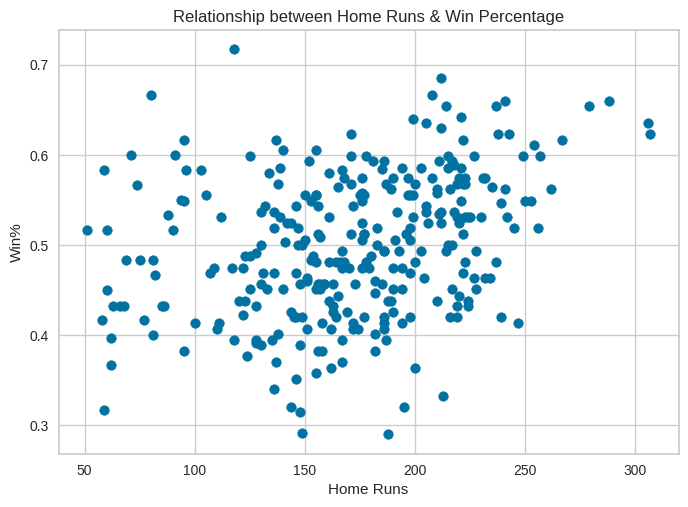

0.3136812417464269

In [23]:
x = final_stats["HR_x"].astype(float)
y = final_stats["Win %"].astype(float)

plt.scatter(x, y)
plt.xlabel("Home Runs")
plt.ylabel("Win%")
plt.title('Relationship between Home Runs & Win Percentage')
plt.show()
correlation = x.corr(y)
correlation

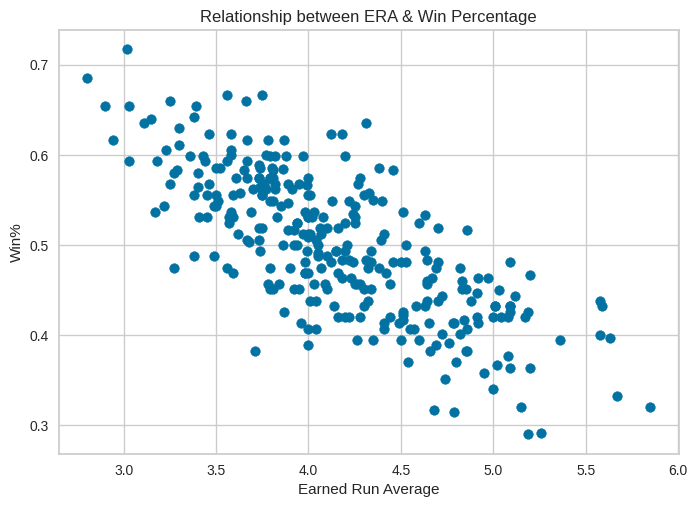

-0.747886122990507

In [24]:
x = final_stats["ERA"].astype(float)
y = final_stats["Win %"].astype(float)

plt.scatter(x, y)
plt.xlabel("Earned Run Average")
plt.ylabel("Win%")
plt.title('Relationship between ERA & Win Percentage')
plt.show()
correlation = x.corr(y)
correlation

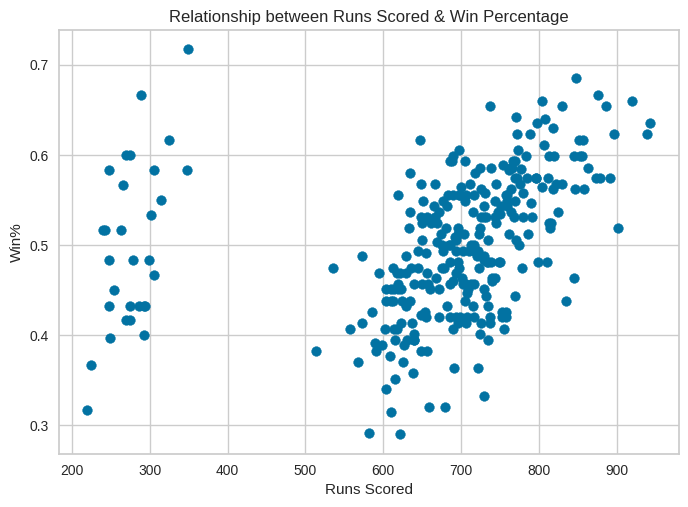

0.30082803081240067

In [25]:
x = final_stats["R"].astype(float)
y = final_stats["Win %"].astype(float)

plt.scatter(x, y)
plt.xlabel("Runs Scored")
plt.ylabel("Win%")
plt.title('Relationship between Runs Scored & Win Percentage')
plt.show()
correlation = x.corr(y)
correlation

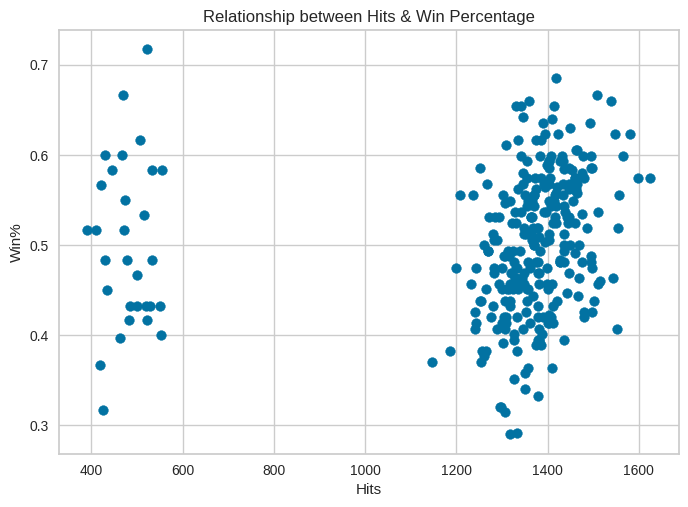

0.09007152713081812

In [26]:
x = final_stats["H_x"].astype(float)
y = final_stats["Win %"].astype(float)

plt.scatter(x, y)
plt.xlabel("Hits")
plt.ylabel("Win%")
plt.title('Relationship between Hits & Win Percentage')
plt.show()
correlation = x.corr(y)
correlation

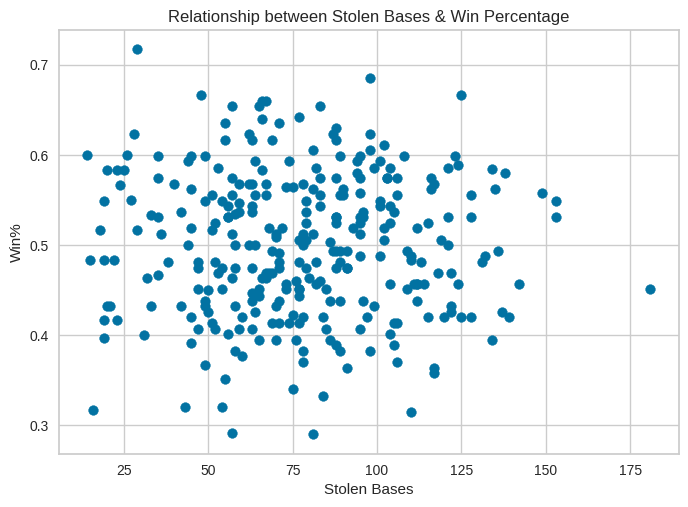

-0.006984063230221341

In [27]:
x = final_stats["SB"].astype(float)
y = final_stats["Win %"].astype(float)

plt.scatter(x, y)
plt.xlabel("Stolen Bases")
plt.ylabel("Win%")
plt.title('Relationship between Stolen Bases & Win Percentage')
plt.show()
correlation = x.corr(y)
correlation

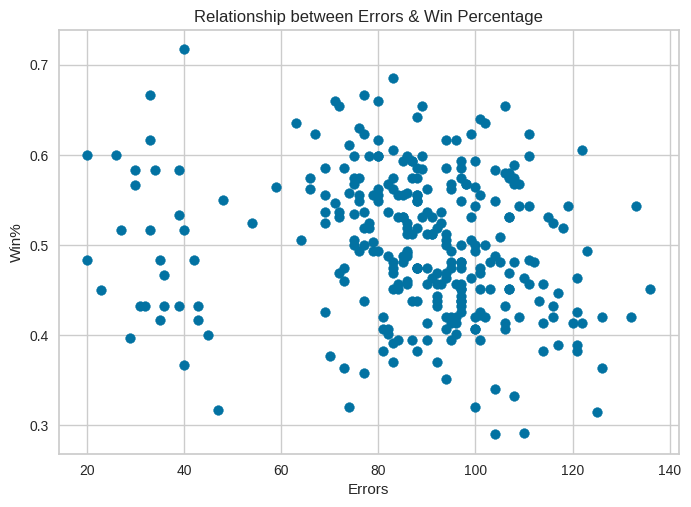

-0.17698678238138482

In [28]:
x = final_stats["E"].astype(float)
y = final_stats["Win %"].astype(float)

plt.scatter(x, y)
plt.xlabel("Errors")
plt.ylabel("Win%")
plt.title('Relationship between Errors & Win Percentage')
plt.show()
correlation = x.corr(y)
correlation

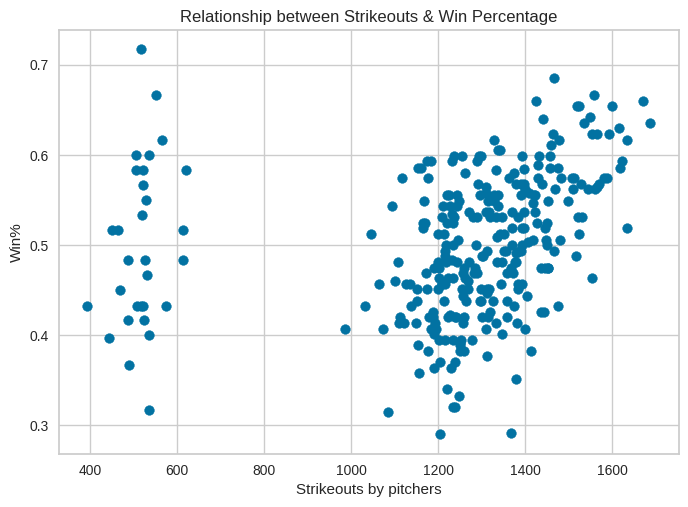

0.2268295802462016

In [29]:
x = final_stats["SO_y"].astype(float)
y = final_stats["Win %"].astype(float)

plt.scatter(x, y)
plt.xlabel("Strikeouts by pitchers")
plt.ylabel("Win%")
plt.title('Relationship between Strikeouts & Win Percentage')
plt.show()
correlation = x.corr(y)
correlation

In [30]:
y = final_stats['Win %'].apply(pd.to_numeric, errors = 'coerce')

feature_names = [
                 'R', 'AB', 'H_x', 'HR_x', 'BB_x', 'SO_x', 'SB', 'CS', 'HBP', 'SF',
                 'ER', 'ERA', 'CG', 'ShO', 'SV', 'H_y', 'HR_y', 'BB_y', 'SO_y',
                 'E', 'DP', 'FP'
                 ]
X = final_stats[feature_names].apply(pd.to_numeric, errors='coerce')

corr_matrix = X.corrwith(y)

for feature, corr in zip(feature_names, corr_matrix):
    print(f"The correlation of {feature} with Win % is {corr:.3f}")

The correlation of R with Win % is 0.301
The correlation of AB with Win % is 0.010
The correlation of H_x with Win % is 0.090
The correlation of HR_x with Win % is 0.314
The correlation of BB_x with Win % is 0.292
The correlation of SO_x with Win % is -0.082
The correlation of SB with Win % is -0.007
The correlation of CS with Win % is -0.159
The correlation of HBP with Win % is 0.206
The correlation of SF with Win % is 0.199
The correlation of ER with Win % is -0.406
The correlation of ERA with Win % is -0.748
The correlation of CG with Win % is 0.148
The correlation of ShO with Win % is 0.162
The correlation of SV with Win % is 0.414
The correlation of H_y with Win % is -0.205
The correlation of HR_y with Win % is -0.283
The correlation of BB_y with Win % is -0.257
The correlation of SO_y with Win % is 0.227
The correlation of E with Win % is -0.177
The correlation of DP with Win % is -0.113
The correlation of FP with Win % is 0.288


In [31]:
# Set the target, y, and features, X
y = final_stats['Win %']

feature_names = [
                 'R', 'AB', 'H_x', 'HR_x', 'BB_x', 'SO_x', 'SB', 'CS', 'HBP', 'SF',
                 'ER', 'ERA', 'CG', 'ShO', 'SV', 'H_y', 'HR_y', 'BB_y', 'SO_y',
                 'E', 'DP', 'FP'
                ]
# Removed variables with less correlation
#feature_names = [
                 #'R', 'H_x', 'HR_x', 'BB_x', 'CS', 'HBP', 'SF',
                 #'ER', 'ERA', 'CG', 'ShO', 'SV', 'H_y', 'HR_y', 'BB_y', 'SO_y',
                 #'E', 'DP', 'FP'
                 #]
X = final_stats[feature_names]

In [32]:
# Scale data
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

# Split data into training and test sets
(X_train, X_test,
 y_train, y_test) = train_test_split(X_scale, y, test_size=0.75)


<Axes: >

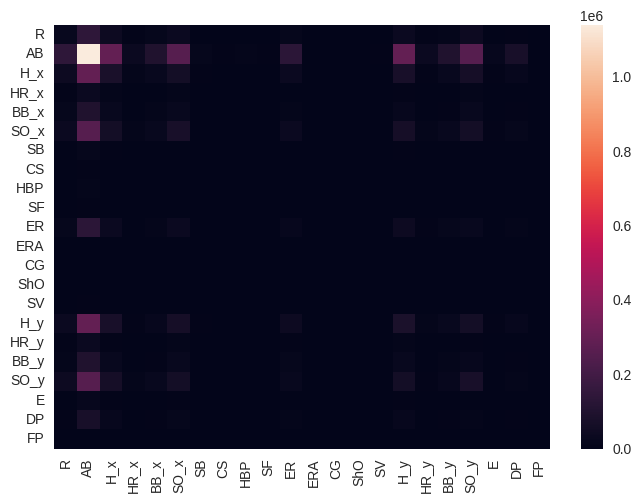

In [33]:
#Display Covariance
sns.heatmap(X.cov())

In [34]:
# Fit a linear regresion
linreg = LinearRegression()
linreg.fit(X_train, y_train)
# y values based on x_train
y_train_pred = linreg.predict(X_train)
# y values based on x_test
y_pred = linreg.predict(X_test)

In [35]:
# Retain coefficients and performance
# create new table and add column names
df_regs = pd.DataFrame(columns=(['Intercept'] + feature_names
                                + ['Train R2', 'Test R2', 'Train MSE', 'Test MSE', 'AverageR2', 'AverageMSE']))

r2_scores = [r2_score(y_train, y_train_pred), r2_score(y_test, y_pred)]
mse_scores = [mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_pred)]
          
# populate columns with linreg data
df_regs.loc['Linear'] = ([linreg.intercept_] + list(linreg.coef_)
                         + [r2_score(y_train, y_train_pred),
                            r2_score(y_test, y_pred), mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_pred), np.mean(r2_scores), np.mean(mse_scores)])

In [36]:
# Set regularization parameter for ridge, lasso, and elasticnet
# balance fit of model to training data WITH magnitude of parameters
# slope is function that is being optimized 

alpha=0.1
l1_ratio=0.1

In [37]:
# Ridge: reduce slope of line close to zero
# minimize ((theta)^2)

ridge = Ridge(alpha=alpha)
ridge.fit(X_train, y_train)
y_train_pred = ridge.predict(X_train)
y_pred = ridge.predict(X_test)

r2_scores = [r2_score(y_train, y_train_pred), r2_score(y_test, y_pred)]
mse_scores = [mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_pred)]

df_regs.loc['Ridge'] = ([ridge.intercept_] + list(ridge.coef_)
                         + [r2_score(y_train, y_train_pred),
                            r2_score(y_test, y_pred), mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_pred), np.mean(r2_scores), np.mean(mse_scores)])

In [38]:
# Lasso: reduce slope of line to zero
# minimize (|theta|)

lasso = Lasso(alpha=alpha, max_iter=100000)
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)

r2_scores = [r2_score(y_train, y_train_pred), r2_score(y_test, y_pred)]
mse_scores = [mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_pred)]

df_regs.loc['Lasso'] = ([lasso.intercept_] + list(lasso.coef_)
                         + [r2_score(y_train, y_train_pred),
                            r2_score(y_test, y_pred), mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_pred), np.mean(r2_scores), np.mean(mse_scores)])

In [39]:
# Elastic Net
# hybrid, minimize both
# (a/2)(1-b)

elastic = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
elastic.fit(X_train, y_train)
y_train_pred = elastic.predict(X_train)
y_pred = elastic.predict(X_test)

r2_scores = [r2_score(y_train, y_train_pred), r2_score(y_test, y_pred)]
mse_scores = [mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_pred)]

df_regs.loc['ElasticNet'] = ([elastic.intercept_] + list(elastic.coef_)
                            + [r2_score(y_train, y_train_pred),
                              r2_score(y_test, y_pred), mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_pred), np.mean(r2_scores), np.mean(mse_scores)])



In [40]:
pd.set_option('display.max_columns', 26)
df_regs


,Intercept,R,AB,H_x,HR_x,BB_x,SO_x,SB,CS,HBP,SF,ER,ERA,...,H_y,HR_y,BB_y,SO_y,E,DP,FP,Train R2,Test R2,Train MSE,Test MSE,AverageR2,AverageMSE
Linear,0.4989,0.1416,-0.0201,-0.0472,-0.0271,-0.0067,-0.0067,-0.0051,0.0039,0.0023,-0.0071,-0.0091,-0.0198,...,-0.0197,-0.0133,-0.0004,0.0096,-0.0213,0.0041,-0.0118,0.9303,0.8301,0.0004,0.0011,0.8802,0.0007
Ridge,0.4987,0.1273,-0.0272,-0.0307,-0.0220,-0.0043,-0.0066,-0.0036,0.0028,0.0031,-0.0065,-0.0105,-0.0189,...,-0.0192,-0.0130,-0.0015,0.0100,-0.0218,0.0043,-0.0116,0.9296,0.8374,0.0004,0.0011,0.8835,0.0007
Lasso,0.4976,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,...,0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0012,0.0050,0.0068,-0.0006,0.0059
ElasticNet,0.5016,0.0203,-0.0000,0.0000,0.0075,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0179,-0.0237,...,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.6236,0.6004,0.0019,0.0027,0.6120,0.0023


In [41]:
result = df_regs[['Train R2', 'Test R2', 'Train MSE', 'Test MSE', 'AverageR2', 'AverageMSE']]
result.head()

,Train R2,Test R2,Train MSE,Test MSE,AverageR2,AverageMSE
Linear,0.9303,0.8301,0.0004,0.0011,0.8802,0.0007
Ridge,0.9296,0.8374,0.0004,0.0011,0.8835,0.0007
Lasso,0.0000,-0.0012,0.0050,0.0068,-0.0006,0.0059
ElasticNet,0.6236,0.6004,0.0019,0.0027,0.6120,0.0023


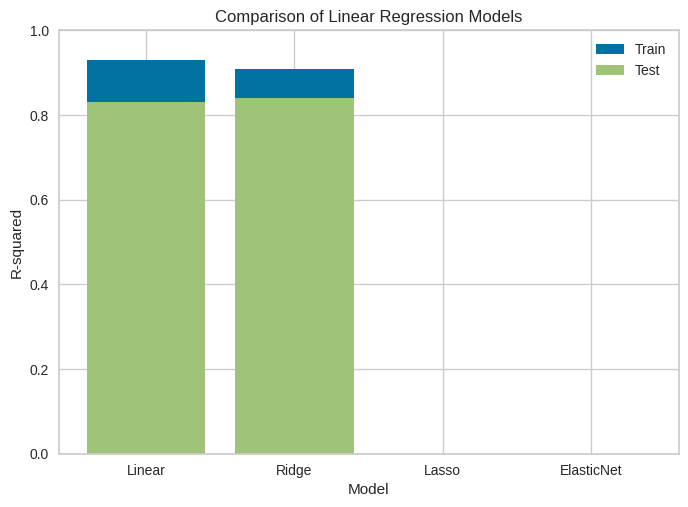

In [42]:
# Create a sample DataFrame with the data
data = {
    'Model': ['Linear', 'Ridge', 'Lasso', 'ElasticNet'],
    'Train R2': [0.9303, 0.9074, 0.0000, 0.0000],
    'Test R2': [0.8301, 0.8403, -0.0012, -0.0012]
}
df = pd.DataFrame(data)

# Get the R-squared values for each model
train_r2 = df['Train R2']
test_r2 = df['Test R2']

# Create a bar chart of the R-squared values
plt.bar(df['Model'], train_r2, label='Train')
plt.bar(df['Model'], test_r2, label='Test')
plt.ylim(0, 1)
plt.xlabel('Model')
plt.ylabel('R-squared')
plt.title('Comparison of Linear Regression Models')
plt.legend()
plt.show()

In [43]:
# Create a list of alphas to cross-validate against
alphas = np.linspace(0.1, 5, 20)

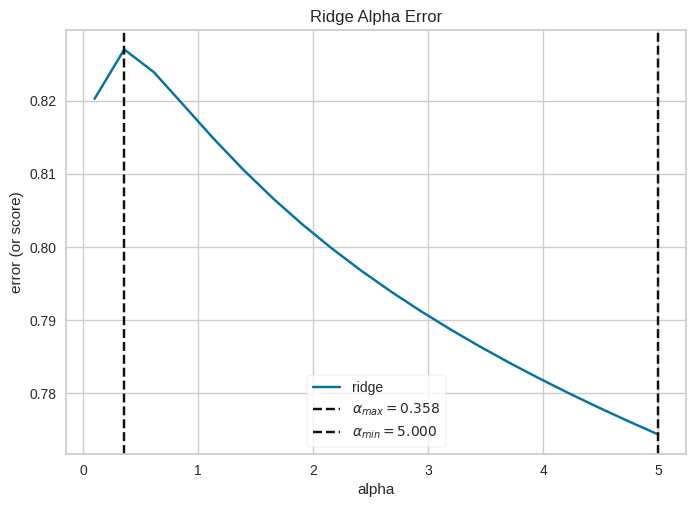

<Axes: title={'center': 'Ridge Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [44]:
# Instantiate the visualizer with 10 fold cross validation
visualizer = ManualAlphaSelection(
    # ridge model that was created earlier
    ridge,
    alphas=alphas,
    cv=10,
    scoring="r2"
)

visualizer.fit(X_train, y_train)
visualizer.show()

In [45]:
# Create a list of l1 values to cross-validate against
l1 = np.linspace(0.1, 1, 20)

In [46]:
parameters = {
    'alpha':alphas,
    'l1_ratio':l1
}

In [47]:
# create a grid search object
grid = GridSearchCV(elastic, param_grid=parameters, cv= 10, scoring='r2')

In [48]:
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=ElasticNet(alpha=0.1, l1_ratio=0.1),
             param_grid={'alpha': array([0.1       , 0.35789474, 0.61578947, 0.87368421, 1.13157895,
       1.38947368, 1.64736842, 1.90526316, 2.16315789, 2.42105263,
       2.67894737, 2.93684211, 3.19473684, 3.45263158, 3.71052632,
       3.96842105, 4.22631579, 4.48421053, 4.74210526, 5.        ]),
                         'l1_ratio': array([0.1       , 0.14736842, 0.19473684, 0.24210526, 0.28947368,
       0.33684211, 0.38421053, 0.43157895, 0.47894737, 0.52631579,
       0.57368421, 0.62105263, 0.66842105, 0.71578947, 0.76315789,
       0.81052632, 0.85789474, 0.90526316, 0.95263158, 1.        ])},
             scoring='r2')

In [49]:
bestParam = grid.best_params_
bestR2Score = grid.best_score_

print("Best Parameters: ", bestParam)
print("Best r2 score: ", bestR2Score)

Best Parameters:  {'alpha': 0.1, 'l1_ratio': 0.1}
Best r2 score:  0.49897190122457324
